# Imports

In [37]:
import pandas as pd
import xlwings as xw
import openpyxl
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import functions
from sklearn import preprocessing
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import yfinance as yf
import datetime as dt
from scipy import stats
import matplotlib.dates as mdates
from scipy.optimize import minimize

# Importing Data into DF

In [38]:
# Treasury Yields
treasury_rates=[]

for year in range(2013,2024):
    file_path = f'../Data/Daily Treasury Par Yield Curve Rates/daily-treasury-rates_{year}.csv'
    treasury_data = pd.read_csv(file_path)
    treasury_rates.append(treasury_data)

# Concatenating the data
all_treasury_data = pd.concat(treasury_rates)

# Dropping unneeded columns
all_treasury_data.drop(["2 Mo","4 Mo"], inplace=True, axis=1)

# Transforming the date
all_treasury_data["Date"]=pd.to_datetime(all_treasury_data["Date"])
all_treasury_data["Year"]=all_treasury_data["Date"].dt.year
all_treasury_data["Month"]=all_treasury_data["Date"].dt.month

# Only keeping the last observation of each quarters' month
all_treasury_data=all_treasury_data.sort_values(by="Date").groupby(["Year","Month"]).last().reset_index()
all_treasury_data=all_treasury_data[all_treasury_data["Month"].isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])].reset_index()

all_treasury_data_quarterly=all_treasury_data[all_treasury_data["Month"].isin([1, 4, 7, 10])].reset_index()

# Dropping unneeded columns and last observation
all_treasury_data.drop(["Year","Month", 'index'], axis=1, inplace=True)
all_treasury_data = all_treasury_data.iloc[:-1,:]

all_treasury_data_quarterly.drop(["Year","Month", 'index'], axis=1, inplace=True)

# Inflation Rate
infrate = functions.data_frame_from_xlsx('../Data/CPI for All Urban Consumers/INFRATE.xlsx', 'FRED Graph!A11:B141')

# Changing the data in our wanted form
infrate = functions.first_row_as_columns(infrate)
infrate = functions.transform_dates(infrate, drop_list = ['index', 'observation_date', 'Date'], needed_months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], drop_last_data = 'Y')


# CPI

cpi = functions.data_frame_from_xlsx('../Data/CPI for All Urban Consumers/CPIAUCSL.xlsx', 'FRED Graph!A11:B141')

# Changing the data in our wanted form
cpi = functions.first_row_as_columns(cpi)
cpi = functions.transform_dates(cpi, drop_list = ['index', 'observation_date', 'Date'], needed_months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], drop_last_data = 'Y')


# Unemployment Rate

unemployment = functions.data_frame_from_xlsx('../Data/Unemployment Rate/UNRATE.xlsx', 'FRED Graph!A11:B199')
unemployment = functions.first_row_as_columns(unemployment)
unemployment = functions.transform_dates(unemployment, drop_list = ['index', 'Date', 'observation_date'], needed_months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

# GDP Data and GDP Growth

gdp = functions.data_frame_from_xlsx('../Data/U.S. Quarterly Gross Domestic Product/GDP.xlsx', 'FRED Graph!A11:B199')
gdp = functions.first_row_as_columns(gdp)
gdp = functions.transform_dates(gdp, drop_list = ['index', 'Date'], needed_months = [1, 4, 7, 10])
gdp['observation_date'] = pd.to_datetime(gdp['observation_date'])

gdp_growth = functions.data_frame_from_xlsx('../Data/U.S. Quarterly Gross Domestic Product/GDP_growth.xlsx', 'FRED Graph!A11:B199')
gdp_growth = functions.first_row_as_columns(gdp_growth)
gdp_growth = functions.transform_dates(gdp_growth, drop_list = ['index', 'Date'], needed_months = [1, 4, 7, 10])
gdp_growth['observation_date'] = pd.to_datetime(gdp_growth['observation_date'])

# All of the data

In this section I put together the data and use Min-Max scaling / standardizing for hopefully better results at the end. Min-Max scaling works in a way that every value gets transformed into:

x_new = (x-min)/(max-min)

In the end I used standardizing but I commented out the part which does the min_max_scaler, so it can be easily changed later on.

Notice that we are not using the previously collected GDP data, since it is the only one with quarterly frequency, it is better to leave it out.

Expected inflation is also useless for us in our case, since from its definition, it is highly correlated with the treasury yields according to efficient market hypothesis, so leave that one out as well.

In [39]:
# Putting together the data and scaling it
#df = pd.concat([all_treasury_data], axis=1)
df = pd.concat([all_treasury_data, cpi, infrate, unemployment], axis=1)
df_scaled = df.drop(columns = 'Date')

"""
x = df_scaled.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
"""

x = df_scaled.values
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)

# Creating a new DataFrame with the scaled data, including the Date column back into the DataFrame
df_scaled = pd.DataFrame(x_scaled, columns=df_scaled.columns)
df_scaled.insert(0, 'Date', df['Date'])

In [40]:
df.to_excel(r"dataframe.xlsx", index=False)

# Quarterly Dataframe

In [41]:
df_quarterly = pd.concat([all_treasury_data_quarterly, gdp_growth, gdp], axis=1)
df_quarterly = df_quarterly.drop(columns = ['level_0', 'observation_date'])

In [42]:
df_quarterly_scaled = df_quarterly.drop(columns = 'Date')

x = df_quarterly_scaled.values
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)

# Creating a new DataFrame with the scaled data, including the Date column back into the DataFrame
df_quarterly_scaled = pd.DataFrame(x_scaled, columns=df_quarterly_scaled.columns)
df_quarterly_scaled.insert(0, 'Date', df_quarterly['Date'])


# Correlation Matrix

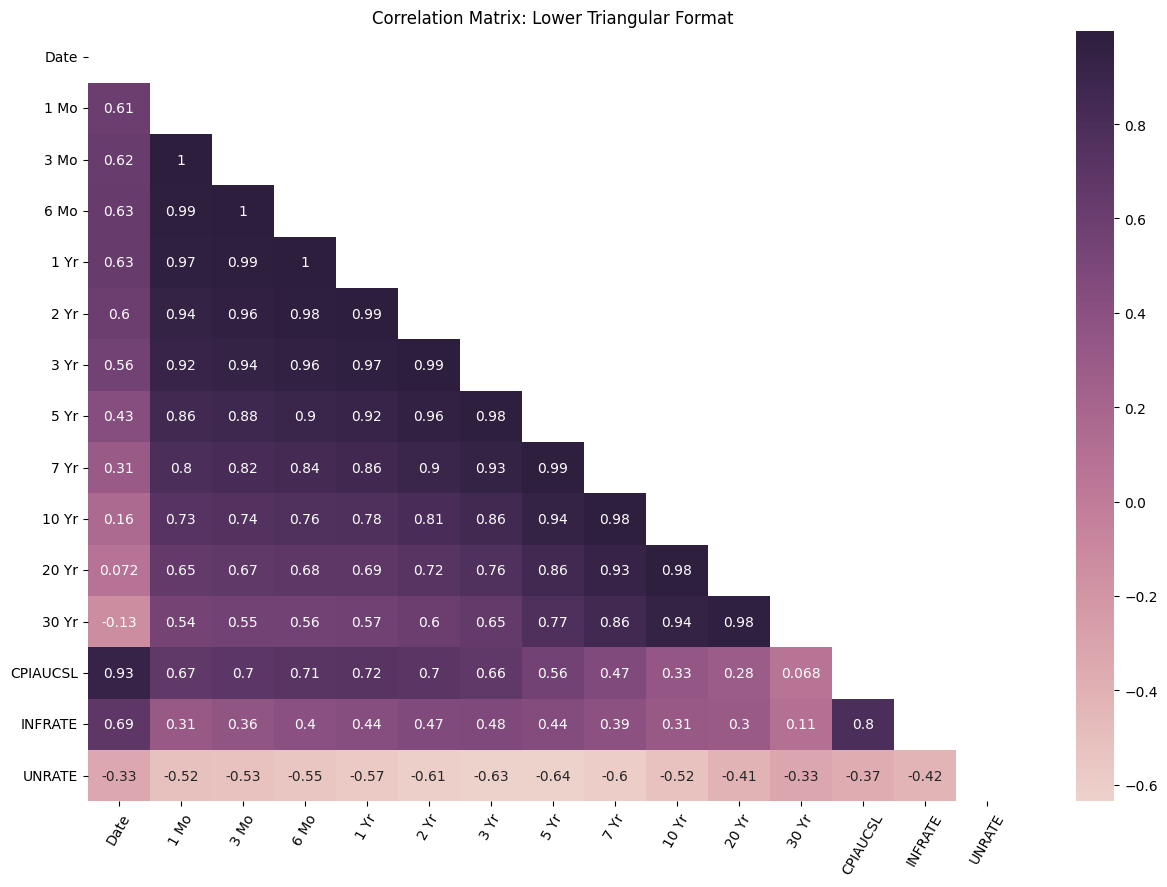

In [43]:
corr = df_scaled.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(15, 10))  # Adjust the figure size as needed

# Draw the heatmap with the mask and correct aspect ratio
sns_heatmap = sns.heatmap(corr, mask=mask, cmap=sns.cubehelix_palette(as_cmap=True), annot=True, cbar=True, ax=ax)

ax.set_title('Correlation Matrix: Lower Triangular Format')

# Rotate x-axis labels
sns_heatmap.set_xticklabels(sns_heatmap.get_xticklabels(), rotation=60)

plt.show()

# Let's visualize the correlation coefficients between the variables CPI, Unemployment rate, 1 and 10 Year Treasury yields.

In [44]:
#functions.visualize_shifts_together4(df, 'Date','1 Yr', '5 Yr', '10 Yr', '30 Yr')

In [45]:
#functions.visualize_shifts_together4(df_scaled, 'Date','6 Mo', '1 Yr', '10 Yr', 'UNRATE')

In [46]:
#functions.visualize_shifts_together3(df_quarterly_scaled, 'Date', '10 Yr', '1 Yr', 'INFRATE')

In [47]:
#functions.visualize_shifts_together3(df_scaled, 'Date', '1 Yr', '10 Yr', 'UNRATE')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


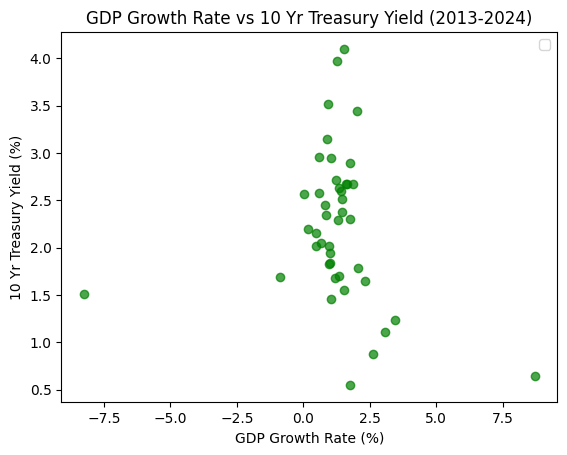

In [48]:
fig, ax = plt.subplots()

ax.scatter(df_quarterly['GDP_Growth'].shift(-1), df_quarterly['10 Yr'], color='green', alpha=0.7)
ax.set_title('GDP Growth Rate vs 10 Yr Treasury Yield (2013-2024)')
ax.set_xlabel('GDP Growth Rate (%)')
ax.set_ylabel('10 Yr Treasury Yield (%)')
ax.legend()

#plt.xlim(-2.5,5)

plt.show()

# Plot before 2020 Differently

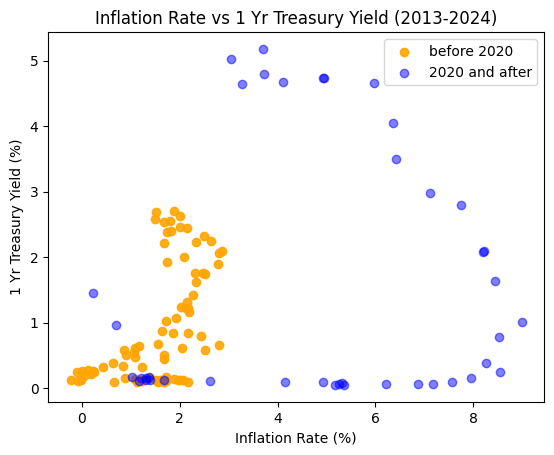

In [49]:
condition = df['Date'] < pd.Timestamp('2020-01-01')

fig, ax = plt.subplots()

ax.scatter(df[condition]['INFRATE'].shift(-3), df[condition]['1 Yr'], color='orange', label='before 2020', alpha=0.9)
ax.scatter(df[~condition]['INFRATE'].shift(-3), df[~condition]['1 Yr'], color='blue', label='2020 and after', alpha=0.5)
ax.set_title('Inflation Rate vs 1 Yr Treasury Yield (2013-2024)')
ax.set_xlabel('Inflation Rate (%)')
ax.set_ylabel('1 Yr Treasury Yield (%)')
ax.legend()

#plt.xlim(0,16)

plt.show()

In [50]:
df

,Date,1 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr,CPIAUCSL,INFRATE,UNRATE
0,2013-01-31,0.04,0.07,0.12,0.15,0.27,0.42,0.88,1.38,2.02,2.79,3.17,232.937,2.01814,7.7
1,2013-02-28,0.07,0.11,0.13,0.17,0.25,0.36,0.77,1.26,1.89,2.71,3.10,232.282,1.518747,7.5
2,2013-03-28,0.04,0.07,0.11,0.14,0.25,0.36,0.77,1.24,1.87,2.71,3.10,231.797,1.138808,7.6
3,2013-04-30,0.03,0.05,0.09,0.11,0.22,0.32,0.68,1.11,1.70,2.49,2.88,231.893,1.390389,7.5
4,2013-05-31,0.03,0.04,0.07,0.14,0.30,0.52,1.05,1.55,2.16,2.95,3.30,232.445,1.715794,7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,2023-06-30,5.24,5.43,5.47,5.40,4.87,4.49,4.13,3.97,3.81,4.06,3.85,304.348,3.271781,3.5
126,2023-07-31,5.48,5.55,5.53,5.37,4.88,4.51,4.18,4.08,3.97,4.22,4.02,306.269,3.718721,3.8
127,2023-08-31,5.52,5.56,5.48,5.37,4.85,4.54,4.23,4.19,4.09,4.39,4.20,307.481,3.694055,3.8
128,2023-09-29,5.55,5.55,5.53,5.46,5.03,4.80,4.60,4.61,4.59,4.92,4.73,NaN,NaN,NaN


In [51]:
df_before_2020 = df[condition]
df_after_2020 = df[~condition]
df_no_nan = df.iloc[:-2, :]

In [52]:
df_no_nan

,Date,1 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr,CPIAUCSL,INFRATE,UNRATE
0,2013-01-31,0.04,0.07,0.12,0.15,0.27,0.42,0.88,1.38,2.02,2.79,3.17,232.937,2.01814,7.7
1,2013-02-28,0.07,0.11,0.13,0.17,0.25,0.36,0.77,1.26,1.89,2.71,3.10,232.282,1.518747,7.5
2,2013-03-28,0.04,0.07,0.11,0.14,0.25,0.36,0.77,1.24,1.87,2.71,3.10,231.797,1.138808,7.6
3,2013-04-30,0.03,0.05,0.09,0.11,0.22,0.32,0.68,1.11,1.70,2.49,2.88,231.893,1.390389,7.5
4,2013-05-31,0.03,0.04,0.07,0.14,0.30,0.52,1.05,1.55,2.16,2.95,3.30,232.445,1.715794,7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,2023-04-28,4.35,5.10,5.06,4.80,4.04,3.75,3.51,3.49,3.44,3.80,3.67,303.294,4.12069,3.7
124,2023-05-31,5.28,5.52,5.46,5.18,4.40,4.04,3.74,3.69,3.64,4.01,3.85,303.841,3.053262,3.6
125,2023-06-30,5.24,5.43,5.47,5.40,4.87,4.49,4.13,3.97,3.81,4.06,3.85,304.348,3.271781,3.5
126,2023-07-31,5.48,5.55,5.53,5.37,4.88,4.51,4.18,4.08,3.97,4.22,4.02,306.269,3.718721,3.8


# Getting p-value for plots

In [53]:
p_values = functions.get_p_value_for_shifts(df_no_nan, 'INFRATE', tenors = ['1 Yr', '10 Yr'])

# Create a DataFrame
pvalues = pd.DataFrame({
    '1yr_pvalue': p_values[0],
    '10yr_pvalue': p_values[1]
})

# Extract the series from the DataFrame
pvalue_series_1yr = pvalues['1yr_pvalue']
pvalue_series_10yr = pvalues['10yr_pvalue']

#Double axis with p value
#functions.visualize_shifts_together_double_y_axis(df_scaled, 'Date', '1 Yr', '10 Yr', 'INFRATE', pvalue_series_10yr, pvalue_series_1yr)

c:\Users\balin\OneDrive\Asztali gép\Thesis\Data\Bálint szakdoga\projekt\notebook\functions.py:301: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{variable}_shift_{shift}"] = df[variable].shift(shift)
c:\Users\balin\OneDrive\Asztali gép\Thesis\Data\Bálint szakdoga\projekt\notebook\functions.py:301: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{variable}_shift_{shift}"] = df[variable].shift(shift)
c:\Users\balin\OneDrive\Asztali gép\Thesis\Data\Bálint szakdoga\projekt\notebook\functions.py:301: Set

# Running the OLS for partial DataFrame

In [54]:
df_partial = df_before_2020.copy()
#df_partial = df_after_2020.copy()

# Let us shift the predicting variables with -1 and -2
# Leaving all of the unnecessary variables out
variables=['INFRATE','UNRATE']

for variable in variables:
    for shift in [1]:
        df_partial[f"{variable}_shift_{shift}"] = df_partial[variable].shift(-3*shift)

# Let's separate the variables
X=df_partial.dropna().copy()
Y=X[['1 Mo', '3 Mo', '6 Mo','1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr', '30 Yr']]
dates = X['Date']
X=X.drop(columns=['Date','1 Mo', '3 Mo', '6 Mo','1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr', '30 Yr'])

# Transform the data with the 1/x connection we have noticed
for column in Y.columns:
   Y[f"{column}_1perX"] = 1/(1 + Y[column])



#We need to add a constant value   
X = sm.add_constant(X)

#Let us finally run the OLS
results = {}
for i in range(Y.shape[1]):  # Iterate over each column in Y.
    model = sm.OLS(Y.iloc[:, i], X[['UNRATE_shift_1', 'const']].astype(float)).fit()  # Fit model for Y's ith column.
    results[Y.columns[i]] = model  # Store the summary with the column name as key.

results['1 Yr_1perX'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             1 Yr_1perX   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     339.0
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           2.59e-30
Time:                        20:33:29   Log-Likelihood:                 69.955
No. Observations:                  81   AIC:                            -135.9
Df Residuals:                      79   BIC:                            -131.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
UNRATE_shift_1     0.1889      0.010     18.413      0.000       0.168       0.209
const             -0.3182      0.052     -6.129      0.000      -0.422      -0.215
==============================================================================
Omnibus:                        2.404   Durbin-Watson:                   0.167
Prob(Omnibus):                  0.301   Jarque-Bera (JB):                1.604
Skew:                          -0.093   Prob(JB):                        0.449
Kurtosis:                       2.336   Cond. No.                         23.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
results['1 Yr_1perX'].params

UNRATE_shift_1    0.188852
const            -0.318202
dtype: float64

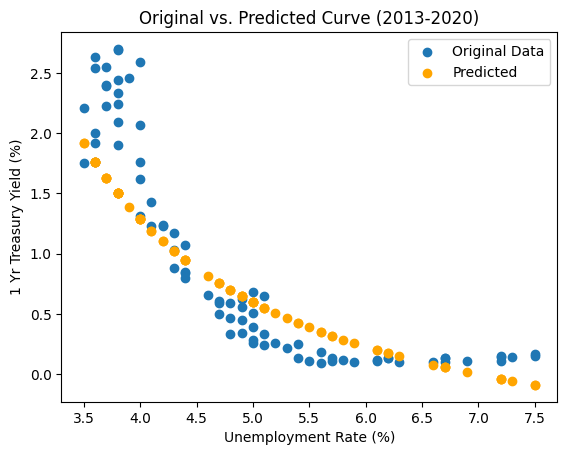

And the predictions are the following:
 [-0.08940716 -0.08940716 -0.05697327 -0.03987418 -0.03987418 -0.03987418
  0.01535763  0.05584989  0.07733178  0.05584989  0.05584989  0.17277498
  0.14736312  0.19933797  0.17277498  0.19933797  0.25624512  0.31882162
  0.28677303  0.35250739  0.31882162  0.3879591   0.42531934  0.42531934
  0.35250739  0.4647465   0.50641697  0.55052784  0.59729994  0.59729994
  0.55052784  0.59729994  0.69985301  0.6469816   0.59729994  0.55052784
  0.69985301  0.6469816   0.69985301  0.6469816   0.59729994  0.6469816
  0.75623157  0.75623157  0.75623157  0.8164782   0.9502853   0.9502853
  0.9502853   1.02486401  1.02486401  0.9502853   1.02486401  1.10537326
  1.10537326  1.19254975  1.28725746  1.19254975  1.28725746  1.28725746
  1.50353942  1.28725746  1.50353942  1.50353942  1.62778024  1.50353942
  1.50353942  1.39051639  1.28725746  1.50353942  1.50353942  1.76499613
  1.62778024  1.76499613  1.62778024  1.62778024  1.91733164  1.76499613
  1.76499613 

In [56]:
fig, ax = plt.subplots()

ax.scatter(X.UNRATE_shift_1, (Y['1 Yr']), label='Original Data')
predictions = results['1 Yr_1perX'].predict()
transformed_predictions = (1 / predictions) -1  # Transforming back
ax.scatter(X.UNRATE_shift_1, transformed_predictions, label='Predicted', color='orange')

plt.title('Original vs. Predicted Curve (2013-2020)')
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('1 Yr Treasury Yield (%)')
plt.legend()
plt.show()

print(f'And the predictions are the following:\n {transformed_predictions}')

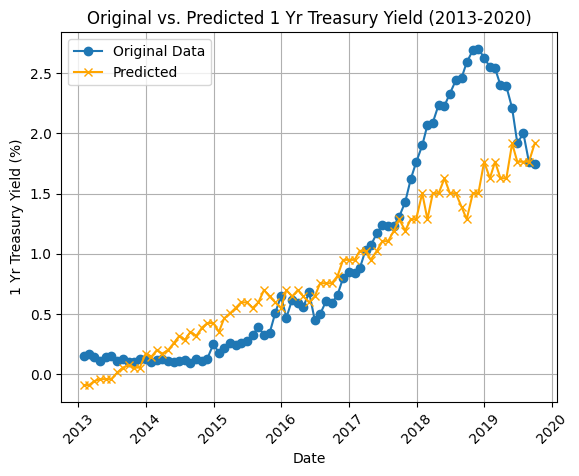

In [57]:
# Plotting
fig, ax = plt.subplots()

ax.plot(dates, Y['1 Yr'], label='Original Data', marker='o')
ax.plot(dates, transformed_predictions, label='Predicted', marker='x', color='orange')

plt.title('Original vs. Predicted 1 Yr Treasury Yield (2013-2020)')
plt.xlabel('Date')
plt.ylabel('1 Yr Treasury Yield (%)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

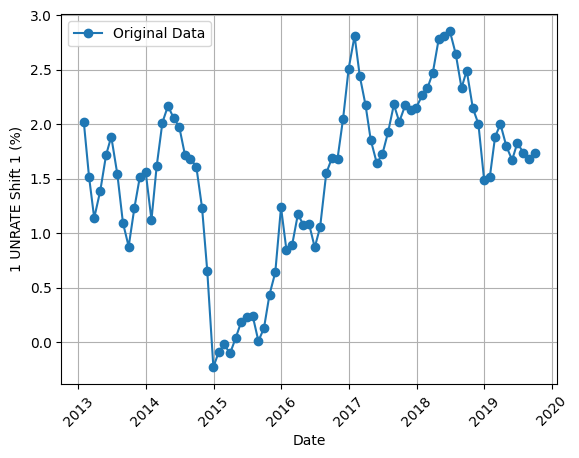

In [58]:
# Plotting
fig, ax = plt.subplots()

ax.plot(dates, X["INFRATE"], label='Original Data', marker='o')
plt.xlabel('Date')
plt.ylabel('1 UNRATE Shift 1 (%)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Extra: More plots, where there are less data on 1 plot

I have added some plots here for better visuality. This is not part of the project but rather an extra section where we can see the same plots on more pictures.

In [59]:
#functions.visualize_shifts(df_scaled, 'Date', 'UNRATE', '1 Yr')

In [60]:
#functions.visualize_shifts(df_scaled, 'Date', 'CPIAUCSL', '1 Yr')

In [61]:
#functions.visualize_shifts(df_scaled, 'Date', 'CPIAUCSL', '10 Yr')

I have added here the scatter plot where there are different kind of series points on one plot. I think it is much better to see this separated.

# SPY Impact on the Yield Curve

Importing data for every day

In [62]:
sp500 = yf.download('^GSPC', start='2013-01-01', end='2023-11-24')
sp500.reset_index(inplace=True)
sp500 = sp500[['Close', 'Date']].rename(columns = {'Close':'sp500'})
sp500['sp500_diff']=sp500['sp500'].diff(1)
sp500['sp500_change']=(sp500['sp500'].diff(1)/sp500['sp500'])

[*********************100%%**********************]  1 of 1 completed


In [63]:


treasury_yields=[]

for year in range(2013,2024):
    file_path = f'../Data/Daily Treasury Par Yield Curve Rates/daily-treasury-rates_{year}.csv'
    treasury_data = pd.read_csv(file_path)
    treasury_yields.append(treasury_data)

# Concatenating the data
treasury_data = pd.concat(treasury_yields)

# Dropping unneeded columns
treasury_data.drop(["2 Mo","4 Mo"], inplace=True, axis=1)

# Transforming the date
treasury_data["Date"]=pd.to_datetime(treasury_data["Date"])
treasury_data["Year"]=treasury_data["Date"].dt.year
treasury_data["Month"]=treasury_data["Date"].dt.month
#treasury_data=treasury_data.sort_values(by="Date").groupby(["Year","Month"]).last().reset_index()
treasury_data.drop(["Year","Month"], axis=1, inplace=True)


#treasury_data = treasury_data.iloc[:-1,:]
#treasury_data.to_excel(r"yields.xlsx", index=False)

In [64]:
# Process each date separately
results = []

# Melt the data to long format
data_long = treasury_data.melt(id_vars='Date', var_name='Maturity', value_name='Rate')

# Convert Maturity to numerical months
maturity_map = {'1 Mo': 1/12, '3 Mo': 3/12, '6 Mo': 6/12, '1 Yr': 1, '2 Yr': 2, '3 Yr': 3, '5 Yr': 5, '7 Yr': 7, '10 Yr': 10, '20 Yr': 20, '30 Yr': 30}
data_long['Maturity'] = data_long['Maturity'].map(maturity_map)

# Initialize a list to collect DataFrames
params_list = []

# Process each date separately
for date, group in data_long.groupby('Date'):
    maturities = group['Maturity'].values
    rates = group['Rate'].values
    initial_params = [0.01, 0.01, 0.01, 1.0]  # Adjust initial guesses if necessary
    
    # Optimize the parameters for this date
    result = minimize(functions.objective_function, initial_params, args=(maturities, rates), method='L-BFGS-B')
    
    if result.success:
        fitted_params = result.x
        # Create a DataFrame for this date and parameters and add to the list
        date_params_df = pd.DataFrame({
            'Date': [date],
            'beta0': [fitted_params[0]],
            'beta1': [fitted_params[1]],
            'beta2': [fitted_params[2]],
            'lambd': [fitted_params[3]]
        })
        params_list.append(date_params_df)
    else:
        print(f"Optimization failed for {date}: {result.message}")

# Concatenate all parameter DataFrames into one
params_df = pd.concat(params_list)

# Merge parameters with the original data for complete analysis
final_data = pd.merge(treasury_data, params_df, on='Date', how='left')

print(final_data.head())

c:\Users\balin\OneDrive\Asztali gép\Thesis\Data\Bálint szakdoga\projekt\notebook\functions.py:332: RuntimeWarning: overflow encountered in exp
  return beta0 + (beta1 + beta2) * ((1 - np.exp(-t / lambd)) / (t / lambd)) - beta2 * np.exp(-t / lambd)
c:\Users\balin\OneDrive\Asztali gép\Thesis\Data\Bálint szakdoga\projekt\notebook\functions.py:332: RuntimeWarning: invalid value encountered in subtract
  return beta0 + (beta1 + beta2) * ((1 - np.exp(-t / lambd)) / (t / lambd)) - beta2 * np.exp(-t / lambd)
c:\Users\balin\OneDrive\Asztali gép\Thesis\Data\Bálint szakdoga\projekt\notebook\functions.py:329: RuntimeWarning: overflow encountered in square
  return np.sum((rates - nelson_siegel_curve(t, beta0, beta1, beta2, lambd)) ** 2)


Optimization failed for 2013-08-13 00:00:00: ABNORMAL_TERMINATION_IN_LNSRCH


c:\Users\balin\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


        Date  1 Mo  3 Mo  6 Mo  1 Yr  2 Yr  3 Yr  5 Yr  7 Yr  10 Yr  20 Yr  \
0 2013-12-31  0.01  0.07  0.10  0.13  0.38  0.78  1.75  2.45   3.04   3.72   
1 2013-12-30  0.01  0.07  0.10  0.13  0.39  0.77  1.71  2.40   2.99   3.66   
2 2013-12-27  0.01  0.07  0.09  0.12  0.40  0.79  1.74  2.44   3.02   3.70   
3 2013-12-26  0.00  0.07  0.09  0.13  0.42  0.81  1.74  2.43   3.00   3.68   
4 2013-12-24  0.01  0.07  0.09  0.14  0.38  0.80  1.73  2.43   2.99   3.66   

   30 Yr     beta0     beta1     beta2     lambd  
0   3.96  5.098879 -5.156175 -4.235216  2.477787  
1   3.90  4.447712 -4.321556 -5.603639  1.546441  
2   3.94  4.485479 -4.360553 -5.673859  1.528091  
3   3.92  4.457871 -4.348061 -5.511159  1.542139  
4   3.90  4.434924 -4.309422 -5.602212  1.521128  


In [65]:
# Sort the data by the 'Date' column
data_sorted = final_data.sort_values(by='Date')
data_sorted.replace('', np.nan, inplace=True)
data_sorted.replace(' ', np.nan, inplace=True)  # If there are spaces considered as empty

cols = ['beta0', 'beta1', 'beta2', 'lambd']
data_sorted[cols] = data_sorted[cols].apply(pd.to_numeric, errors='coerce')

# Drop rows where any of the beta or lambda columns are NaN
data_cleaned = data_sorted.dropna(subset=['beta0', 'beta1', 'beta2', 'lambd'])
data=data_sorted

# Convert 'Date' to datetime format if not already
data['Date'] = pd.to_datetime(data['Date'])

# List of columns to clean
columns_to_clean = ['beta0', 'beta1', 'beta2', 'lambd']

# Process each column to remove outliers
for column in columns_to_clean:
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtering out the outliers by setting them to NaN
    data.loc[(data[column] < lower_bound) | (data[column] > upper_bound), column] = pd.NA

# Use forward fill to handle the NaN values
data[columns_to_clean] = data[columns_to_clean].ffill()


# Check the result
print(f"Original data count: {len(data)}")

Original data count: 2727


In [66]:
#data_sorted.to_excel(r"yield_curves.xlsx", index=False)

data['datestr'] = data['Date'].dt.strftime("%Y%m%d")
sp500['datestr'] = sp500['Date'].dt.strftime("%Y%m%d")

data = data.merge(sp500.drop(columns=['Date']), how= 'left', on = 'datestr')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


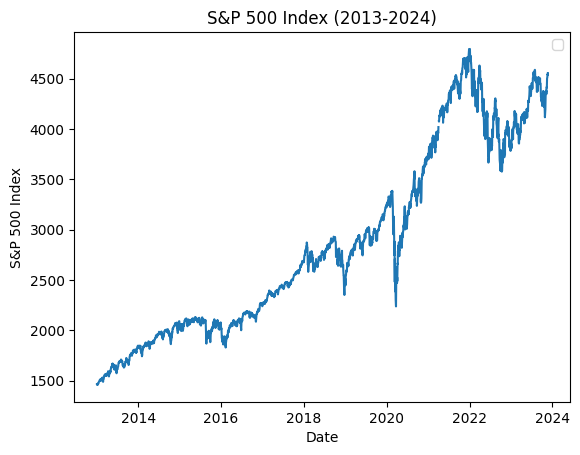

In [67]:
fig, ax = plt.subplots()
ax.plot(data["Date"], data.sp500)
ax.set_title('S&P 500 Index (2013-2024)')
ax.set_xlabel('Date')
ax.set_ylabel('S&P 500 Index')
ax.legend()

#plt.xlim(0,16)

plt.show()

(-10.0, 10.0)

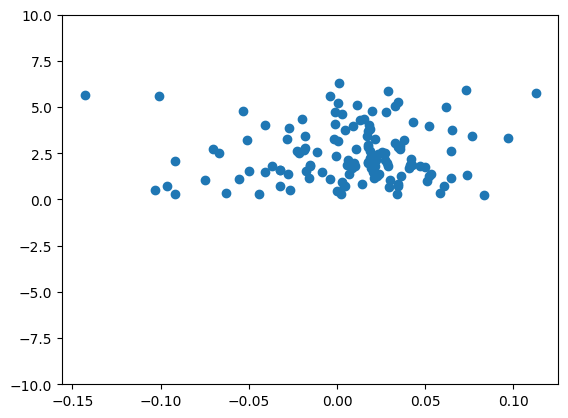

In [68]:
plotdf = data.copy()
plotdf['Year'] = plotdf['Date'].dt.year
plotdf['Month'] = plotdf['Date'].dt.month

# Only keeping the last observation of each quarters' month
plotdf=plotdf.sort_values(by="Date").groupby(["Year","Month"]).last().reset_index()

plotdf_quarterly=plotdf[plotdf["Month"].isin([1, 4, 7, 10])].reset_index()
plotdf=plotdf[plotdf["Month"].isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])].reset_index()

plotdf = plotdf.iloc[:-1,:]
plotdf_quarterly = plotdf_quarterly.iloc[:-1,:]

plotdf['sp500_diff']=plotdf['sp500'].diff(1)
plotdf['sp500_change']=(plotdf['sp500'].diff(1)/plotdf['sp500'])

plt.scatter(plotdf['sp500_change'], plotdf['lambd'])


plt.ylim(-10, 10)

In [69]:
df_quarterly.columns

Index(['Date', '1 Mo', '3 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr',
       '10 Yr', '20 Yr', '30 Yr', 'GDP_Growth', 'GDP'],
      dtype='object')

In [70]:
df_quarterly = df_quarterly.drop(columns=['Date', '1 Mo', '3 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr','10 Yr', '20 Yr', '30 Yr'])
df_all_quarterly = pd.concat([plotdf_quarterly, df_quarterly], axis=1)
df_all_quarterly = df_all_quarterly.dropna()

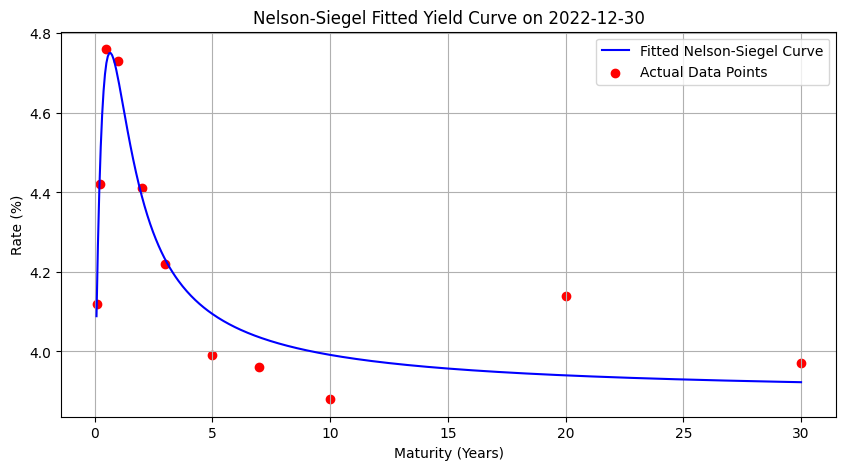

In [71]:
# Choose a date to analyze, for example the first date in the dataset
input_date = '2022-12-30'
single_date_data = data[data['Date'] == input_date]

# Assuming maturities are stored in one of the columns, adjust the column names as needed
maturities = np.array([1/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])  # Update this array based on your actual maturity columns
rates = single_date_data.iloc[0][['1 Mo', '3 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr', '30 Yr']].values

# Optimize the parameters
result = minimize(functions.objective_function, initial_params, args=(maturities, rates), method='L-BFGS-B')

result = minimize(functions.objective_function, initial_params, args=(maturities, rates), method='L-BFGS-B')
fitted_params = result.x

# Generating a range of maturities for plotting the curve
t_plot = np.linspace(min(maturities), max(maturities), 500)
fitted_curve = functions.nelson_siegel_curve(t_plot, *fitted_params)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(t_plot, fitted_curve, label='Fitted Nelson-Siegel Curve', color='blue')
plt.scatter(maturities, rates, color='red', label='Actual Data Points')
plt.title(f'Nelson-Siegel Fitted Yield Curve on {input_date}')
plt.xlabel('Maturity (Years)')
plt.ylabel('Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

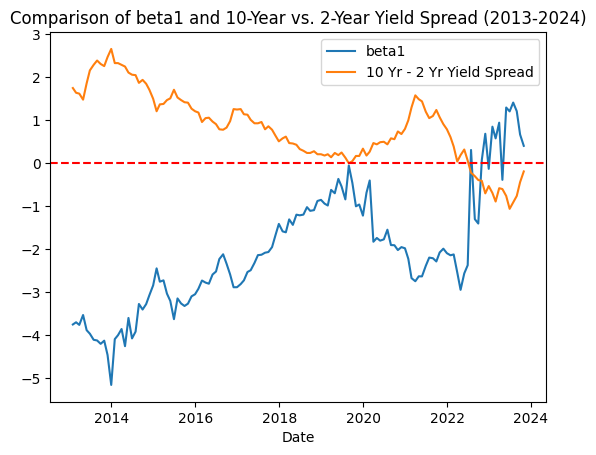

In [72]:
# Plotting
fig, ax = plt.subplots()

ax.plot(plotdf["Date"], plotdf['beta1'], label="beta1")
ax.plot(plotdf["Date"], plotdf['10 Yr']-plotdf['2 Yr'], label="10 Yr - 2 Yr Yield Spread")
plt.title('Comparison of beta1 and 10-Year vs. 2-Year Yield Spread (2013-2024)')
plt.axhline(y=0.0, color='r', linestyle='--')
plt.xlabel('Date')
plt.legend()
plt.show()

In [73]:
plotdf_scaled = plotdf.drop(columns = 'Date')

x = plotdf_scaled.values
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)

# Creating a new DataFrame with the scaled data, including the Date column back into the DataFrame
plotdf_scaled = pd.DataFrame(x_scaled, columns=plotdf_scaled.columns)
plotdf_scaled.insert(0, 'Date', plotdf['Date'])

In [74]:
p_values = functions.get_p_value_for_shifts(plotdf_scaled, 'sp500', tenors = ['1 Yr', '10 Yr'])

# Create a DataFrame
pvalues = pd.DataFrame({
    '1yr_pvalue': p_values[0],
    '10yr_pvalue': p_values[1]
})

# Extract the series from the DataFrame
pvalue_series_1yr = pvalues['1yr_pvalue']
pvalue_series_10yr = pvalues['10yr_pvalue']

#Double axis with p value
#functions.visualize_shifts_together_double_y_axis(plotdf_scaled, 'Date', '1 Yr', '10 Yr', 'sp500', pvalue_series_10yr, pvalue_series_1yr)

In [75]:
#functions.visualize_shifts_together3(plotdf_scaled, 'Date', '10 Yr', '1 Yr', 'sp500')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


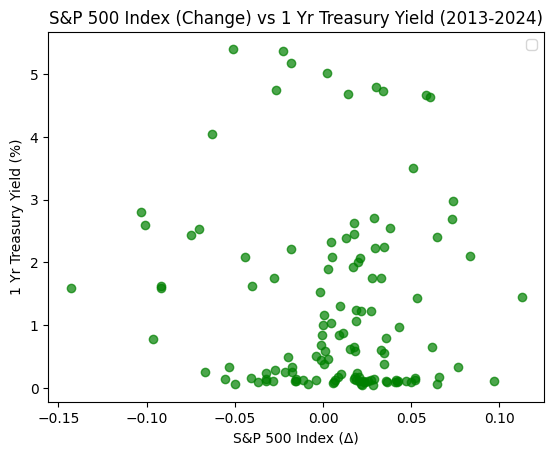

In [76]:
fig, ax = plt.subplots()

ax.scatter(plotdf['sp500_change'].shift(-3), plotdf['1 Yr'], color='green', alpha=0.7)
ax.set_title('S&P 500 Index (Change) vs 1 Yr Treasury Yield (2013-2024)')
ax.set_xlabel('S&P 500 Index (Δ)')
ax.set_ylabel('1 Yr Treasury Yield (%)')
ax.legend()

#plt.xlim(-2.5,5)

plt.show()

In [77]:
df_all = pd.concat([df, plotdf], axis=1)

In [78]:
df_all.columns

Index(['Date', '1 Mo', '3 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr',
       '10 Yr', '20 Yr', '30 Yr', 'CPIAUCSL', 'INFRATE', 'UNRATE', 'index',
       'Year', 'Month', 'Date', '1 Mo', '3 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr',
       '5 Yr', '7 Yr', '10 Yr', '20 Yr', '30 Yr', 'beta0', 'beta1', 'beta2',
       'lambd', 'datestr', 'sp500', 'sp500_diff', 'sp500_change'],
      dtype='object')

In [79]:
df_all_quarterly.columns

Index(['index', 'Year', 'Month', 'Date', '1 Mo', '3 Mo', '6 Mo', '1 Yr',
       '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr', '30 Yr', 'beta0',
       'beta1', 'beta2', 'lambd', 'datestr', 'sp500', 'sp500_diff',
       'sp500_change', 'GDP_Growth', 'GDP'],
      dtype='object')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


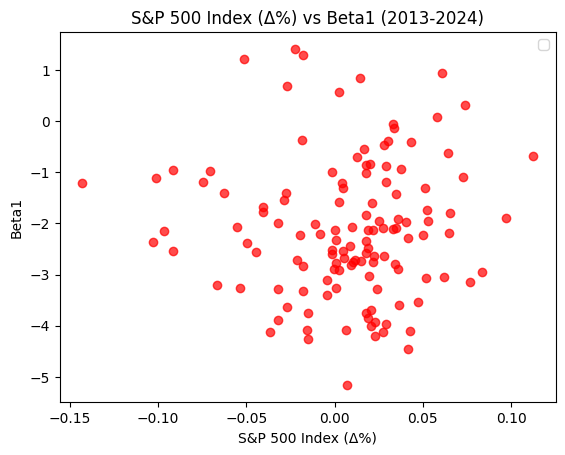

In [80]:
fig, ax = plt.subplots()

ax.scatter(df_all['sp500_change'].shift(-3), df_all['beta1'], color='red', alpha=0.7)
ax.set_title('S&P 500 Index (Δ%) vs Beta1 (2013-2024)')
ax.set_xlabel('S&P 500 Index (Δ%)')
ax.set_ylabel('Beta1')
ax.legend()

plt.show()

                            OLS Regression Results                            
Dep. Variable:                  beta1   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     192.7
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           1.73e-26
Time:                        20:34:02   Log-Likelihood:                -149.13
No. Observations:                 119   AIC:                             302.3
Df Residuals:                     117   BIC:                             307.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.5199      0.332    -19.665      0.0

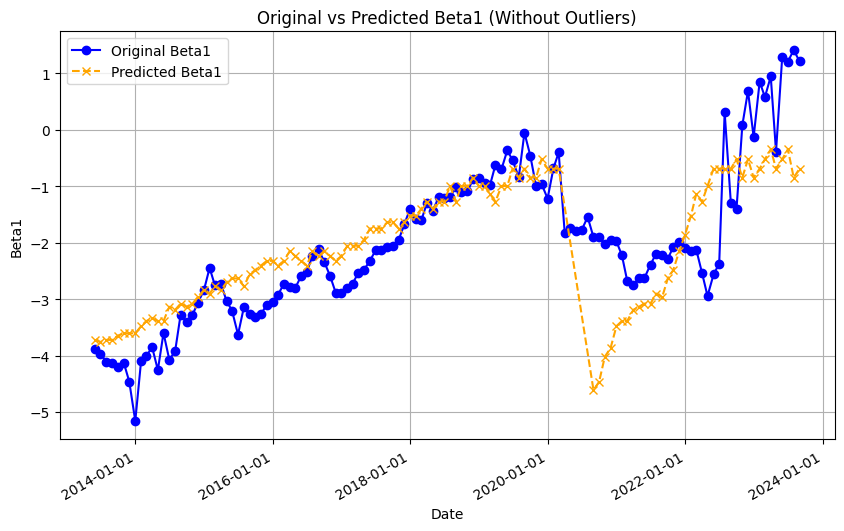

In [81]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats

# Clean the data
# Convert all columns to numeric, coercing errors to NaN
df_all = df_all.apply(pd.to_numeric, errors='coerce')

# Drop rows with any NaN values (or handle them as needed)
df_all = df_all.dropna()

# Check for duplicate columns and handle them
df_all = df_all.loc[:, ~df_all.columns.duplicated()]

# Ensure the 'Date' column is in datetime format
df_all['Date'] = pd.to_datetime(df_all['Date'])

# Shift the unemployment rate back by 3 periods
df_all['shifted_unrate'] = df_all['UNRATE'].shift(3)

# Apply inverse transformation to the shifted unemployment rate
df_all['inv_unrate'] = 1 / df_all['shifted_unrate']
df_all.replace([np.inf, -np.inf], np.nan, inplace=True)
df_all.dropna(inplace=True)

# Remove specific outliers manually based on the threshold
# Define a threshold to remove outliers with high unemployment rate
unemployment_rate_threshold = 8
df_filtered = df_all[df_all['UNRATE'] < unemployment_rate_threshold]

# Define the dependent variable
Y = df_filtered['beta1']

# Define the independent variable
X = df_filtered[['inv_unrate']]

# Add a constant to the independent variables (intercept term)
X = sm.add_constant(X)

# Perform the OLS regression without outliers
model_filtered = sm.OLS(Y, X).fit()

# Make predictions without outliers
predictions_filtered = model_filtered.predict(X)

# Print the summary of the regression without outliers
print(model_filtered.summary())

# Plot the original and predicted values without outliers on a time series plot
plt.figure(figsize=(10, 6))
plt.plot(df_all['Date'], df_all['beta1'], label='Original Beta1', color='blue', marker='o')
plt.plot(df_filtered['Date'], predictions_filtered, label='Predicted Beta1', color='orange', linestyle='--', marker='x')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Beta1')
plt.title('Original vs Predicted Beta1 (Without Outliers)')
plt.legend()

# Format the dates on the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

# Rotate the x-axis labels for better readability
plt.gcf().autofmt_xdate()

# Show plot
plt.grid(True)
plt.show()


                            OLS Regression Results                            
Dep. Variable:                  beta1   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     120.9
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           7.76e-20
Time:                        20:34:02   Log-Likelihood:                -164.02
No. Observations:                 121   AIC:                             332.0
Df Residuals:                     119   BIC:                             337.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.7495      0.353    -16.296      0.0

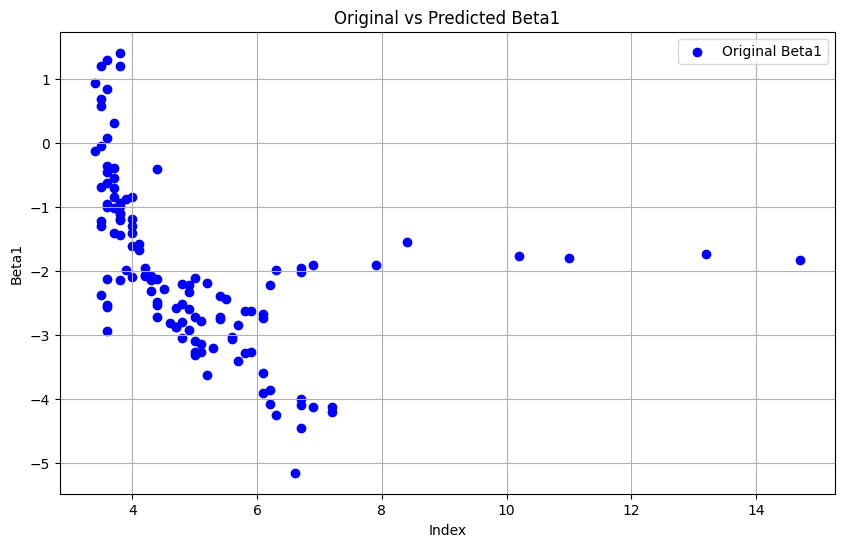

In [82]:
# Clean the data
# Convert all columns to numeric, coercing errors to NaN
df_all = df_all.apply(pd.to_numeric, errors='coerce')

# Drop rows with any NaN values (or handle them as needed)
df_all = df_all.dropna()

# Shift the unemployment rate back by 3 periods
df_all['shifted_unrate'] = df_all['UNRATE'].shift(3)

# Define the independent variables and apply inverse transformation to unemployment_rate
df_all['inv_unrate'] = 1 / df_all['shifted_unrate']
df_all.replace([np.inf, -np.inf], np.nan, inplace=True)
df_all.dropna(inplace=True)

# Define the dependent variable
Y = df_all['beta1']

X = df_all['inv_unrate']

# Add a constant to the independent variables (intercept term)
X = sm.add_constant(X)

# Perform the OLS regression
model = sm.OLS(Y, X).fit()

# Make predictions
predictions = model.predict(X)

# Print the summary of the regression
print(model.summary())

# Plot the original and predicted values
plt.figure(figsize=(10, 6))
plt.scatter(df_all['UNRATE'], Y, label='Original Beta1', color='blue')
#plt.scatter(df_all['UNRATE'], predictions, label='Predicted Beta1', color='red')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Beta1')
plt.title('Original vs Predicted Beta1')
plt.legend()

# Show plot
plt.grid(True)
plt.show()